<a href="https://colab.research.google.com/github/imceballos/udd_homeworks/blob/main/Tarea2_MLAplicado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h2>Modelos de lenguaje y clasificación de texto</h2>

Autor: Israel Ceballos

Profesor: Alonso Astroza

El objetivo de este trabajo es crear un clasificador de **reviews** en base a reseñas de **Amazon**

## *Instalación de libreria fastai*

In [ ]:
!pip install fastai

In [ ]:
!pip install fastai-ulmfit

     |████████████████████████████████| 1.2MB 9.8MB/s 
     |████████████████████████████████| 194kB 25.9MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
from fastai.text import *
from fastai.text.all import *

from fastai_ulmfit.pretrained import *

Crearemos la carpeta data, esta nos servira pronto para almacenar la data 

In [ ]:
path = Path('data')
dest = path
dest.mkdir(parents=True, exist_ok=True)

## <h2>Autenticación y descarga en GCP </h2>

La información esta alojada en GCP (Google Cloud Platform), para poder acceder a ella debe logerarse con su cuenta alonsoastroza@gmail.com, esta cuenta tiene habilitado los permisos para acceder a descargar la infromación.

In [ ]:
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=N5sG7aYPIfr3WrvplseP5pj6Gv73NU&prompt=consent&access_type=offline&code_challenge=uKUK2ueB0RfK0gmbhcWAXUfOoaaP717blwYgfn9U_SU&code_challenge_method=S256

Enter verification code: 4/1AX4XfWgrcqTwmvfwXh0YKlJ_2np40pIw4ZUoEMWSz5YZlg5PMytgyatL3qU

You are now logged in as [eliizabeth.fren@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


To take a quick anonymous survey, run:
  $ gcloud survey



### <h3>Descargamos la información de dataset_es_train</h3>

In [ ]:
!gsutil cp -r  gs://tareaml2/dataset_es_train.json data/

Copying gs://tareaml2/dataset_es_train.json...
\ [1 files][ 73.9 MiB/ 73.9 MiB]                                                
Operation completed over 1 objects/73.9 MiB.                                     


###<h3>Descargamos la información de dataset_es_test</h3>

In [ ]:
!gsutil cp -r gs://tareaml2/dataset_es_test.json data/

Copying gs://tareaml2/dataset_es_test.json...
/ [1 files][  1.8 MiB/  1.8 MiB]                                                
Operation completed over 1 objects/1.8 MiB.                                      


##<h2>Carga de los datos (Pregunta 2.1)</h2>

In [ ]:
import pandas as pd

Conjunto de entrenamiento

In [ ]:
df_train = pd.read_json('data/dataset_es_train.json', lines=True)
df_train.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8 meses y no he recibido respuesta del fabricante,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ni nosotros que sabemos inglés, ni un informático, después de una hora fue capaz de instalarlo",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,"Te obligan a comprar dos unidades y te llega solo una y no hay forma de reclamar, una autentica estafa, no compreis!!",solo llega una unidad cuando te obligan a comprar dos,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo puedo decir que tras dos meses de espera.... sigo sin el producto y tuve que contactar con Amazon para reclamar su reembolso. Amazon un 10 . Se hace cargo del problema, pero yo e desembolsado mi dinero y en dos meses me lo devuelven Perdida de tiempo TOTAL. Sin palabras. Y Ustedes deciden",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


Conjunto de validación

In [ ]:
df_test = pd.read_json('data/dataset_es_test.json', lines=True)
df_test.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0038754,product_es_0113523,reviewer_es_0580071,1,no me llego el articulo me lo mando por correos normal sin seguimiento y nunca me llego tota un desastre,no me llego,es,wireless
1,es_0748979,product_es_0017036,reviewer_es_0819733,1,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,es,home
2,es_0411746,product_es_0138642,reviewer_es_0508607,1,Estoy muy decepcionado con el vendedor ya que el pedido no me llegó a tiempo y no cumplió los plazos de envío y era una cosa que necesitaba urgente. Para colmo me pongo en contacto con el vendedor y no da señales. No recomiendo nada,ESTAFA EN EL ENVÍO,es,toy
3,es_0786686,product_es_0170887,reviewer_es_0491157,1,"Mi valoración no es sobre el producto sino sobre AMAZON. Ofrecéis el producto a 299€ y tras varios días me devolvéis el dinero porque os habéis equivocado en el anuncio, según vosotros, ahora es 399€. Es la primera vez que me ocurre esto. Cuando he comprado en cualquier sitio y el precio marcado no se correspondía con el valor de caja siempre me lo han vendido con el precio marcado. Es inverosímil lo ocurrido, pero la ultima palabra me la dará la oficina del consumidor",Estafa de Amazon,es,home
4,es_0429700,product_es_0710642,reviewer_es_0008745,1,Pues tenía interés en este libro y probé la versión kindle. se abre la portada pero nada más. parece una mala broma pero me iba a gastar el dedo de tanto tratar que pasara de página de alguna forma. No puedo valorar nada de nada.,No conseguí pasar de la portada en Kindle,es,digital_ebook_purchase


###<h3>Número de stars y largo de reseñas</h3>

Conjunto de entrenamiento

In [ ]:
df_train['stars'].value_counts()

5    40000
4    40000
3    40000
2    40000
1    40000
Name: stars, dtype: int64

In [ ]:
reviews_train = df_train[['stars', 'review_body']].apply(lambda x: [x['stars'], len(x['review_body'])], axis=1).tolist()
df_reviews_train = pd.DataFrame(reviews_train, columns=['stars','len_reviews'])

In [ ]:
df_reviews_train.groupby('stars').sum()

,len_reviews
stars,
1,6115339
2,6737550
3,6215212
4,5694288
5,5498193


Conjunto de validación

In [ ]:
df_test['stars'].value_counts()

3    1000
2    1000
5    1000
1    1000
4    1000
Name: stars, dtype: int64

In [ ]:
reviews_test = df_test[['stars', 'review_body']].apply(lambda x: [x['stars'], len(x['review_body'])], axis=1).tolist()
df_reviews_test = pd.DataFrame(reviews_test, columns=['stars','len_reviews'])

In [ ]:
df_reviews_test.groupby('stars').sum()

,len_reviews
stars,
1,156122
2,164685
3,155265
4,143903
5,139596


##<h2>Entrenamiento del modelo (Pregunta 2.2)</h2>

###<h3>Tratamiento de los datos</h3>

Para entrenar este modelo usaremos ULMFIT, el cual se encuentra disponible en la siguiente url:

In [ ]:
url = 'http://bit.ly/ulmfit-eswiki'
tok = tokenizer_from_pretrained(url)

Concatenación de dataframes

In [ ]:
df_train['indicator'] = 0
df_test['indicator'] = 1

In [ ]:
df_final_p1 = pd.concat([df_test, df_train])

In [ ]:
df_final_p1.shape

(205000, 9)

Extraemos la información desde el *review_body* para aislarla en *df_lm_train*

In [ ]:
df_lm_train = df_train[['review_body']]
df_lm_train.head()

,review_body
0,Nada bueno se me fue ka pantalla en menos de 8 meses y no he recibido respuesta del fabricante
1,"Horrible, nos tuvimos que comprar otro porque ni nosotros que sabemos inglés, ni un informático, después de una hora fue capaz de instalarlo"
2,"Te obligan a comprar dos unidades y te llega solo una y no hay forma de reclamar, una autentica estafa, no compreis!!"
3,"No entro en descalificar al vendedor, solo puedo decir que tras dos meses de espera.... sigo sin el producto y tuve que contactar con Amazon para reclamar su reembolso. Amazon un 10 . Se hace cargo del problema, pero yo e desembolsado mi dinero y en dos meses me lo devuelven Perdida de tiempo TOTAL. Sin palabras. Y Ustedes deciden"
4,Llega tarde y co la talla equivocada


In [ ]:
dblocks = DataBlock(blocks=(TextBlock.from_df('review_body', tok=tok, is_lm=True)),
                    get_x=ColReader('text'), 
                    splitter=ColSplitter('indicator'))

dls = dblocks.dataloaders(df_final_p1, bs=64, seq_len=80)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
learn_p1 = language_model_from_pretrained(dls, url=url, drop_mult=1, metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(valley=tensor(0.0021))

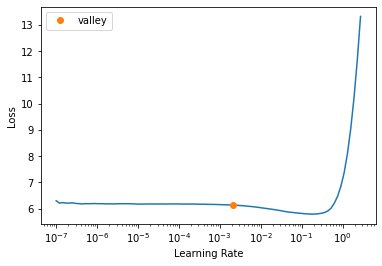

In [ ]:
learn_p1.lr_find()

In [ ]:
lr_p1 = 8e-3

In [ ]:
learn_p1.fit_one_cycle(1, lr_p1 , moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.139252,3.918314,0.260259,50.315540,06:26


In [ ]:
learn_p1.unfreeze()
learn_p1.fit_one_cycle(5, slice(lr_p1/100,lr_p1), moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.917222,3.756862,0.277747,42.813873,07:03
1,3.795038,3.639951,0.289877,38.089951,07:02
2,3.694077,3.568990,0.297234,35.480740,07:02
3,3.604466,3.522070,0.302961,33.854439,07:02
4,3.558575,3.511916,0.304442,33.512413,07:05


In [ ]:
learn_p1.save('learner_preg_1')

Path('models/learner_preg_1.pth')

In [ ]:
learn_p1.save_encoder('finetuned_language_model_encoder')

###<h3>Descarga del modelo</h3>

En caso de querer contar con el modelo preparado para su uso, se puede descargar desde GCP siguiendo los pasos anteriores con su correo.

In [ ]:
path = Path('models')
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
!gsutil cp -r  gs://tareaml2/learner_p1.pth models/

Copying gs://tareaml2/learner_p1.pth...
\ [1 files][301.1 MiB/301.1 MiB]                                                
Operation completed over 1 objects/301.1 MiB.                                    


In [ ]:
learn_p1 = learn_p1.load('learner_p1')

##<h2>Resultados de la clasificación (Pregunta 2.3)</h2>

Generaremos tres reseñas en base al texto **"El producto llego en mal estado y como era de esperar"** con los valores de temperature: 0.5, 0.75, 1.75, 10. A partir de esto, analizaremos la diferencia en los textos generados con cada uno de los casos.

In [ ]:
TEXT = "El producto llego en mal estado y como era de esperar"
N_WORDS = 80
N_SENTENCES = 3
preds = [learn_p1.predict(TEXT, N_WORDS, temperature=0.5) 
         for _ in range(N_SENTENCES)]

In [ ]:
print("\n".join(preds))

▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado ▁y ▁como ▁era ▁de ▁esperar , ▁no ▁se ▁puede ▁pedir ▁más . ▁xxmaj ▁la ▁calidad ▁de ▁imagen ▁es ▁pésima . ▁xxmaj ▁la ▁calidad ▁del ▁sonido ▁no ▁es ▁mala . ▁xxbos ▁xxmaj ▁muy ▁buena ▁calidad , ▁pero ▁al ▁poco ▁tiempo ▁se ▁ha ▁roto ▁la ▁cremallera . ▁xxbos ▁xxmaj ▁el ▁producto ▁no ▁viene ▁con ▁la ▁tapa ▁ni ▁se ▁enciende , ▁la ▁batería ▁no ▁dura ▁el ▁día , ▁no ▁tiene ▁nada ▁que ▁ver ▁con ▁la ▁foto ▁y ▁la ▁calidad ▁de ▁imagen ▁es ▁pésima , ▁la ▁batería ▁dura ▁bastante
▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado ▁y ▁como ▁era ▁de ▁esperar , ▁me ▁ha ▁llegado ▁roto ▁y ▁el ▁vendedor ▁no ▁lo ▁hace ▁responsable . ▁xxbos ▁xxmaj ▁el ▁producto ▁está ▁bien , ▁pero ▁se ▁puede ▁ver ▁en ▁la ▁imagen . ▁xxmaj ▁no ▁es ▁el ▁mismo ▁modelo ▁que ▁en ▁la ▁foto , ▁aunque ▁no ▁es ▁exactamente ▁el ▁mismo . ▁xxmaj ▁es ▁bastante ▁pequeño , ▁lo ▁que ▁no ▁me ▁gusta ▁es ▁que ▁no ▁cubre ▁toda ▁la ▁pantalla . ▁xxmaj ▁por ▁lo ▁demas ▁bien . ▁xxbos ▁xxmaj ▁se ▁lo ▁

In [ ]:
TEXT = "El producto llego en mal estado y como era de esperar"
N_WORDS = 80
N_SENTENCES = 3
preds = [learn_p1.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [ ]:
print("\n".join(preds))

▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado ▁y ▁como ▁era ▁de ▁esperar . ▁xxmaj ▁lo ▁he ▁devuelto ▁y ▁me ▁devolvieron ▁el ▁dinero ▁xxbos ▁xxmaj ▁no ▁me ▁gusta ▁el ▁producto . ▁xxmaj ▁el ▁reparto ▁no ▁del ▁producto ▁es ▁muy ▁malo . ▁xxmaj ▁el ▁vendedor ▁no ▁responde . ▁xxmaj ▁es ▁lo ▁que ▁me ▁han ▁enviado . ▁xxmaj ▁espero ▁que ▁me ▁devuelvan ▁el ▁dinero . ▁xxmaj ▁no ▁recomiendo ▁estas ▁compras . ▁xxbos ▁xxmaj ▁me ▁ha ▁gustado ▁que ▁esta ▁muy ▁bien ▁acabada ▁pero ▁el ▁tacto ▁es ▁pésimo ▁ , ▁no ▁sé ▁que ▁tal ▁la ▁original ,
▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado ▁y ▁como ▁era ▁de ▁esperar ▁la ▁calidad ▁de ▁la ▁imagen ▁es ▁algo ▁baja , ▁pero ▁por ▁el ▁precio ▁que ▁tiene ▁va ▁bien ▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁muy ▁bien ▁embalado ▁y ▁bien ▁protegido . ▁xxmaj ▁no ▁hay ▁nadie ▁que ▁lo ▁pueda ▁poner , ▁viene ▁con ▁todo ▁lo ▁necesario ▁para ▁paños ▁de ▁limpieza ▁de ▁la ▁pantalla ▁y ▁con ▁toallitas ▁suficientes ▁para ▁limpieza ▁y ▁limpieza . ▁xxmaj ▁muy ▁recomendable .

In [ ]:
TEXT = "El producto llego en mal estado y como era de esperar"
N_WORDS = 80
N_SENTENCES = 3
preds = [learn_p1.predict(TEXT, N_WORDS, temperature=1.75) 
         for _ in range(N_SENTENCES)]

In [ ]:
print("\n".join(preds))

▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado ▁y ▁como ▁era ▁de ▁esperar ▁respuesta ▁devuelto . ▁cápsulas ▁funciona ▁america ' porque ▁solidifica ▁rancio ▁tras ▁varios ▁ciclos ▁ultra ▁champú ▁parecidos ▁no ▁vale ▁.... ▁jajaja ▁una ▁verguenza ▁fue ▁enviar ▁esto ▁en ▁dato ▁crema ▁febrero ▁vestido ▁deja ▁exponer ▁fotos ▁bolsas ▁gustaba ▁probarlo ▁sueltas ▁descontento s ▁f ▁requiera ▁caducado ▁goteo ▁que ▁relojero s ▁si ▁campo ▁actualizo ▁mayor ▁acabo ▁substitu y ▁y ▁ya ▁desaparece ▁la ▁descontento ▁toca ▁provar ▁creo ▁q ▁producto año ▁pueden ▁hablar ▁una ▁persona ▁que ▁cole ▁ingles ria ▁xxbos ▁iluminacion ▁excesivamente ▁grande ▁a ▁reseñas ▁retina ▁flujo
▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado ▁y ▁como ▁era ▁de ▁esperar la ▁avería ▁xxbos ▁desde ▁costaba ▁dejar ▁descubierto ▁este ▁lucha ▁traslada ▁ya ▁en ▁primera ▁licencia ▁precisamente ▁encarga ▁paseos perfecto ▁youtube ▁20 ▁minutos ▁! ▁xxbos ▁acopla ▁alumbra ▁bien ▁aspirar ▁configurar ▁pulpo ▁nasal ▁libro ; ▁lástima ▁ya

In [ ]:
TEXT = "El producto llego en mal estado, "
N_WORDS = 80
N_SENTENCES = 3
preds = [learn_p1.predict(TEXT, N_WORDS, temperature=10) 
         for _ in range(N_SENTENCES)]

In [ ]:
print("\n".join(preds))

▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado , ▁trazos ▁jabones ▁conducto ▁india ▁induce ▁cortocircuito ro ▁mordedor ▁colocan ▁similares ▁mías ▁fundidas ▁deluxe ▁jugadores amos $ ▁planos ▁tomadura ▁ruta ▁coger ▁compañeros ▁cochecito ▁alturas ▁rompiera ▁varias ▁ganchos ▁listón ▁maximo jes ▁arranque ▁flauta ▁humidificador ▁lei ▁marioneta ▁romántico ▁escuche ▁uds ▁modifica ▁sinónimo ▁basic ▁fm ▁estanco ▁pitorro ▁aclarar ▁picadora ▁compartimentos tidas ▁ensalada ▁contracturas ▁pintura ▁informado ▁extenso comprar ▁antojo ▁consola ▁dirigida ▁perspectiva ▁servidor ▁ocurrio ▁general ▁opte ▁3 prefiero ▁encajo ▁core ▁elegancia ▁liado ▁mensajeria ▁soldaduras ▁deshacen ▁bases ▁joy ▁monopoly ▁negros ▁tensores ▁colgando ▁barcelona ▁descargar ▁u ▁diadema
▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado , ▁aunq ▁viñeta ▁trajes ista ▁surcos ▁joven ▁vitaminas da ▁garantizada ▁perdi ▁manta ▁batidora ▁autor ▁consiguen ▁alegro ▁vicio ▁publique ▁acostumbrarte ▁refiere ▁paseos ▁puntuación ▁au ▁sume

En base al siguiente [link](https://pytorch-nlp-tutorial-ny2018.readthedocs.io/en/latest/day2/sampling.html), consideremos que el aumento se relaciona con que tan fuerte muestreamos la distribución, a medida que el más alto el valor de **temperature** más uniforme es la distribución y cuando el valor es bajo, se observan pocas diferencias entre los textos generados.

En palabras más simples, si observamos el primer caso (**temperature=0.5**) se puede observar una alta similitud en las palabras usadas por el generador como pantalla o vendedor, el uso de palabras y conectores similares hace que la diferencias entre sentencias sea más baja. Por otro lado, a medida que aumenta el valor de temperature la distribución de palabras tiende a ser más uniforme, en el sentido que se usa una mayor cantidad de palabras con una frequencia baja o igual a uno, esta uniformidad trae como consecuencia que el texto generado pierda coherencia.



##<h2>Clasificación según una menor cantidad de stars (Pregunta 2.4)</h2>

Para la siguiente sección haremos uso de un Datablock junto a un ColSplitter del indicator, esto permitira separar 

In [ ]:
df_final_p2 = df_final_p1[['review_body','stars', 'indicator']]

In [ ]:
df_final_p2.head()

,review_body,stars,indicator
0,no me llego el articulo me lo mando por correos normal sin seguimiento y nunca me llego tota un desastre,1,1
1,"la mensajería horrible, no compro mas",1,1
2,Estoy muy decepcionado con el vendedor ya que el pedido no me llegó a tiempo y no cumplió los plazos de envío y era una cosa que necesitaba urgente. Para colmo me pongo en contacto con el vendedor y no da señales. No recomiendo nada,1,1
3,"Mi valoración no es sobre el producto sino sobre AMAZON. Ofrecéis el producto a 299€ y tras varios días me devolvéis el dinero porque os habéis equivocado en el anuncio, según vosotros, ahora es 399€. Es la primera vez que me ocurre esto. Cuando he comprado en cualquier sitio y el precio marcado no se correspondía con el valor de caja siempre me lo han vendido con el precio marcado. Es inverosímil lo ocurrido, pero la ultima palabra me la dará la oficina del consumidor",1,1
4,Pues tenía interés en este libro y probé la versión kindle. se abre la portada pero nada más. parece una mala broma pero me iba a gastar el dedo de tanto tratar que pasara de página de alguna forma. No puedo valorar nada de nada.,1,1


In [ ]:
dblocks_p2 = DataBlock(blocks=(TextBlock.from_df('review_body'), CategoryBlock),
                       get_x=ColReader('text'), splitter=ColSplitter('indicator'))


In [ ]:
df_final_p1 = df_final_p1.astype({"stars": str})

In [ ]:
dls_blk = DataBlock(blocks = (TextBlock.from_df(text_cols = "review_body", seq_len = 80),
                              CategoryBlock),
                    get_x = ColReader(cols = "text"), get_y = ColReader(cols="stars"),
                    splitter=ColSplitter('indicator'))

In [ ]:
df_final_p1.dtypes

review_id           object
product_id          object
reviewer_id         object
stars               object
review_body         object
review_title        object
language            object
product_category    object
indicator            int64
dtype: object

In [ ]:
dls_clf = dls_blk.dataloaders(df_final_p1, bs=64, seq_len=80)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
dls_clf.show_batch()

,text,category
0,"xxbos xxmaj hago estos cambios en mi opinión , no por el producto , si no por el vendedor . xxmaj me puse en contacto con el vendedor para que me diera una solución sobre el problema de conectar los discos a través de un xxup hub . xxmaj me dijo que tenia que funcionar , y que si no me enviaría otro sin costo . xxmaj seguí sus instrucciones y como no funcionaron , me pidieron que enviara el aparato a una dirección internacional asumiendo yo el coste ( y fuera de la mediación de xxmaj amazon ) , xxmaj cuando le pregunte por esos costes ( que son superiores al precio del articulo ) , me indicaron que los pagara , que luego ya me los devolverían . y que luego también me enviarían uno nuevo . xxmaj me ha parecido todo muy informal y poco ético .",5
1,"xxbos xxmaj es la segunda trona portátil de este tipo que compro en xxmaj amazon por lo que la review es parecida . xxmaj es sin lugar a dudas un objeto imprescindible si sales a comer / cenar fuera o simplemente quieres sentar a tu hijo en una silla y que quede a una altura adecuada estando seguro . xxmaj con respecto a su seguridad nada que objetar . xxmaj la trona va atada a la silla con una correa , la cual va agarrada de forma regulable en el respaldo . xxmaj además tiene una cincha que se ata por debajo a la silla , aunque sin fuerza regulable . xxmaj si bien es verdad que la otra trona que tuve tenía tres enganches , esta queda bien agarrada a la silla también . xxmaj el bebé va atado por dos correas que vienen a hacer el mismo efecto",5
2,"xxbos xxmaj me compré este set de bandas porque tengo problemas de espalda y el fisio me dijo que necesito fortalecer la musculatura de la espalda y como no tengo mucho tiempo me vienen genial para hacer ejercicio en casa . xxmaj el set está compuesto de 5 bandas de diferentes colores , cada color se corresponde con una resistencia diferente de la banda . xxmaj me compré el set porque al no haberlas usado nunca no sabía de qué resistencia necesitaba y así tenía todas y la verdad es que compensa , sale mucho mejor comprar un set que comprar varias bandas separadas . xxmaj es un set muy completo , además de las 5 bandas viene con 2 asas o agarraderas de mano y otras dos de tobillo , para ejercicios de piernas , y viene también con un anclaje de pared , súper útil para ciertos ejercicios",5
3,"xxbos xxmaj el monitor es increíble , viniendo de un 27 "" xxmaj full xxup hd con panel xxup va se nota la diferencia nada más encenderlo . xxmaj el problema con los paneles xxup ips ( aunque cada vez menos ) es que te la juegas y en mi caso el bleeding era más que notable y tenía varios píxeles muertos , además de problemas de conexión con el displayport , que de vez en cuando no detectaba la señal o se iba unos segundos . xxmaj también comentar que el monitor es muy bueno para producir y consumir contenido multimedia , incluso a la hora de jugar no hay ghosting aparente , pero a la hora de hacer cualquier otra cosa se vuelve muy pesado ya que o subes bastante el escalado de xxmaj windows o a una distancia de visionado normal las letras son realmente pequeñas .",3
4,"xxbos xxmaj del producto no puedo decir nada , pero sí del vendedor . xxmaj después de esperar más de una semana más tarde de la recepción estimada del producto , veo un mensaje en el que comentan que el pedido se demora y que están contactando con la mensajería para poder volver a poner en circulación el envío . xxmaj espero dos días más y al no recibir el envío , me pongo en contacto con el vendedor , que me responde que lo siente , que el producto me lo van a abonar y que no se habían dado cuenta que el que quedaba estaba en mal estado . xxmaj que espero que les xxunk . xxmaj no voy a xxunk nada , porque si no me pongo yo en contacto con ellos aún sigo esperando . xxmaj era un regalo muy importante , para un cumpleaños de",1
5,"xxbos xxmaj la caja cumple con su función , es de plastico de calidad ( igual que el de otras marcas que cuestan un poco más ) , la medida es la

In [ ]:
learn_clf = text_classifier_learner(dls_clf, AWD_LSTM, drop_mult=0.3,metrics = accuracy).to_fp16()

In [ ]:
learn_clf.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.513817,1.466319,0.336400,04:03


SuggestedLRs(valley=tensor(0.0003))

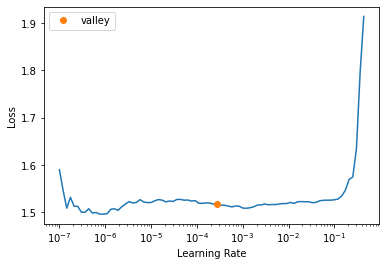

In [ ]:
learn_clf.lr_find()

In [ ]:
learn_clf.unfreeze()
learn_clf.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.024396,1.005451,0.556400,05:00


In [ ]:
learn_p2 = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
learn_p2.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-02
Min loss divided by 10: 9.12E-02


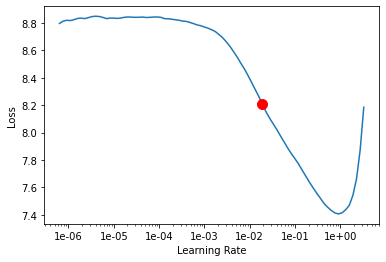

In [ ]:
learn_p2.recorder.plot(suggestion=True)
min_grad_lr = learn_p2.recorder.min_grad_lr

In [ ]:
learn_p2.fit_one_cycle(3, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored

In [ ]:
df_final_p2 = df_final_p1
df_final_p2['stars'] = df_final_p2['stars'].apply(lambda x: '1-2' if x in ['1','2'] else ('3-4' if x in ['3','4'] else '5'))

In [ ]:
df_final_p2.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,indicator
0,es_0038754,product_es_0113523,reviewer_es_0580071,1-2,no me llego el articulo me lo mando por correos normal sin seguimiento y nunca me llego tota un desastre,no me llego,es,wireless,1
1,es_0748979,product_es_0017036,reviewer_es_0819733,1-2,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,es,home,1
2,es_0411746,product_es_0138642,reviewer_es_0508607,1-2,Estoy muy decepcionado con el vendedor ya que el pedido no me llegó a tiempo y no cumplió los plazos de envío y era una cosa que necesitaba urgente. Para colmo me pongo en contacto con el vendedor y no da señales. No recomiendo nada,ESTAFA EN EL ENVÍO,es,toy,1
3,es_0786686,product_es_0170887,reviewer_es_0491157,1-2,"Mi valoración no es sobre el producto sino sobre AMAZON. Ofrecéis el producto a 299€ y tras varios días me devolvéis el dinero porque os habéis equivocado en el anuncio, según vosotros, ahora es 399€. Es la primera vez que me ocurre esto. Cuando he comprado en cualquier sitio y el precio marcado no se correspondía con el valor de caja siempre me lo han vendido con el precio marcado. Es inverosímil lo ocurrido, pero la ultima palabra me la dará la oficina del consumidor",Estafa de Amazon,es,home,1
4,es_0429700,product_es_0710642,reviewer_es_0008745,1-2,Pues tenía interés en este libro y probé la versión kindle. se abre la portada pero nada más. parece una mala broma pero me iba a gastar el dedo de tanto tratar que pasara de página de alguna forma. No puedo valorar nada de nada.,No conseguí pasar de la portada en Kindle,es,digital_ebook_purchase,1


In [ ]:
dls_blk_part2 = DataBlock(blocks = (TextBlock.from_df(text_cols = "review_body", seq_len = 80),
                              CategoryBlock),
                    get_x = ColReader(cols = "text"), get_y = ColReader(cols="stars"),
                    splitter=ColSplitter('indicator'))

In [ ]:
dls_clf_part2 = dls_blk_part2.dataloaders(df_final_p2, bs=64, seq_len=80)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
learn_clf_part2 = text_classifier_learner(dls_clf_part2, AWD_LSTM, drop_mult=0.3,metrics = accuracy).to_fp16()

In [ ]:
learn_clf_part2.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.934815,0.912884,0.551600,04:11


SuggestedLRs(valley=tensor(0.0005))

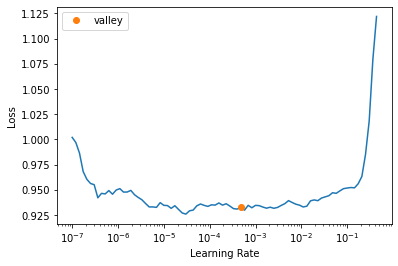

In [ ]:
learn_clf_part2.lr_find()

In [ ]:
learn_clf_part2.unfreeze()
learn_clf_part2.fit_one_cycle(1, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.629436,0.605410,0.719200,05:02


In [ ]:
df_final_p3 = df_final_p1
df_final_p3['stars'] = df_final_p3['stars'].apply(lambda x: '1-2-3' if x in ['1','2','3'] else '4-5')

In [ ]:
dls_blk_part2_1 = DataBlock(blocks = (TextBlock.from_df(text_cols = "review_body", seq_len = 80),
                              CategoryBlock),
                    get_x = ColReader(cols = "text"), get_y = ColReader(cols="stars"),
                    splitter=ColSplitter('indicator'))

In [ ]:
dls_clf_part2_1 = dls_blk_part2_1.dataloaders(df_final_p3, bs=64, seq_len=80)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
learn_clf_part2_1 = text_classifier_learner(dls_clf_part2_1, AWD_LSTM, drop_mult=0.3,metrics = accuracy).to_fp16()

In [ ]:
learn_clf_part2_1.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.000000,0.000000,1.000000,04:07
